This notebook peforms Villarubia's blind tip reconstruction from noise-free image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

## Blind-tip reconstruction from Image

In [3]:
T = [0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 70.0, 100.0]
P_array = []
loss_array = []

for t in T
    m_P = similar(tip)
    m_P .= 0.0

    itip_estimate!(m_P, images[1:20], thresh=t)

    loss = 0.0
    for image in images_randn[1:20]
        loss += mean((idilation(ierosion(image, m_P), m_P) .- image).^2)
    end
    loss = loss / length(images_randn[1:20])
        
    push!(P_array, m_P)
    push!(loss_array, loss)
end

Processed 20 image
46 refinements 
Processed 20 image
45 refinements 
Processed 20 image
43 refinements 
Processed 20 image
36 refinements 
Processed 20 image
37 refinements 
Processed 20 image
32 refinements 
Processed 20 image
23 refinements 
Processed 20 image
9 refinements 


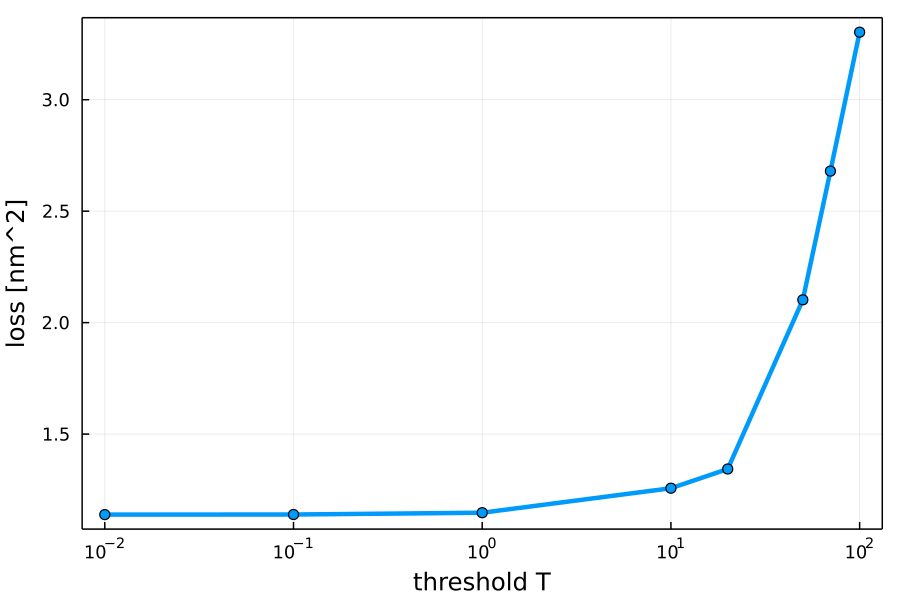

In [4]:
plot(T, loss_array / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=3.0, markershape=:circle, dpi=150, fmt=:png, color=1)

xlabel!("threshold T", fontsize=35)
p = ylabel!("loss [nm^2]", fontsize=35)

In [5]:
savefig(p, "blindtip_original01.png")

In [6]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

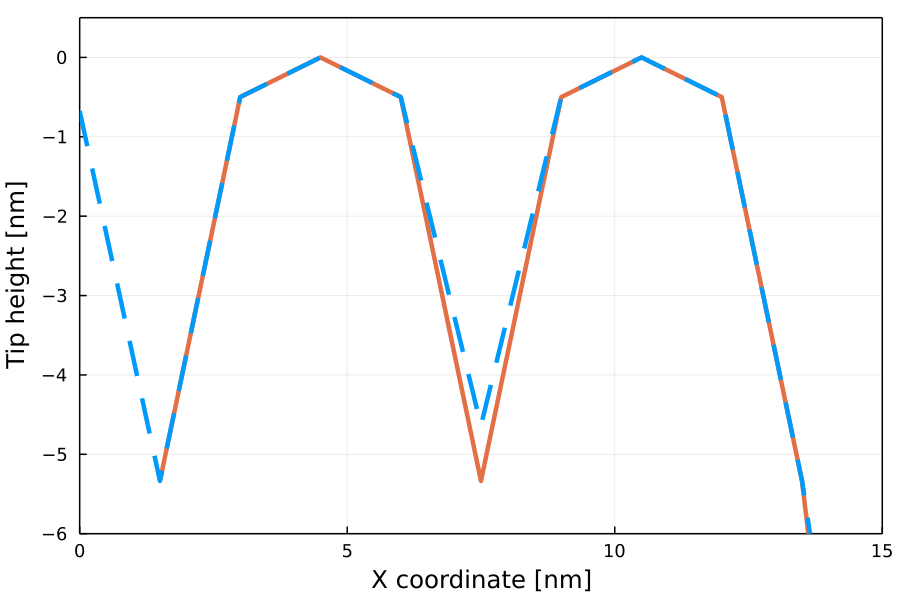

In [11]:
plot(collect(1:11) .* resolution / 10.0, tip[4, :] / 10.0, linewidth=3, label="ground truth", legend=:bottomright, color=2)
p = plot!((collect(1:11) .+ -1) .* resolution / 10.0, translate_tip_mean(P_array[1])[4, 1:end] / 10.0, linewidth=3, label="reconstruction", framestyle = :box, linestyle=:dash, dpi=150, fmt=:png, color=1, legend=nothing)
ylims!((-6, 0.5))
xlims!((0, 15))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [8]:
savefig(p, "blindtip_original02.png")

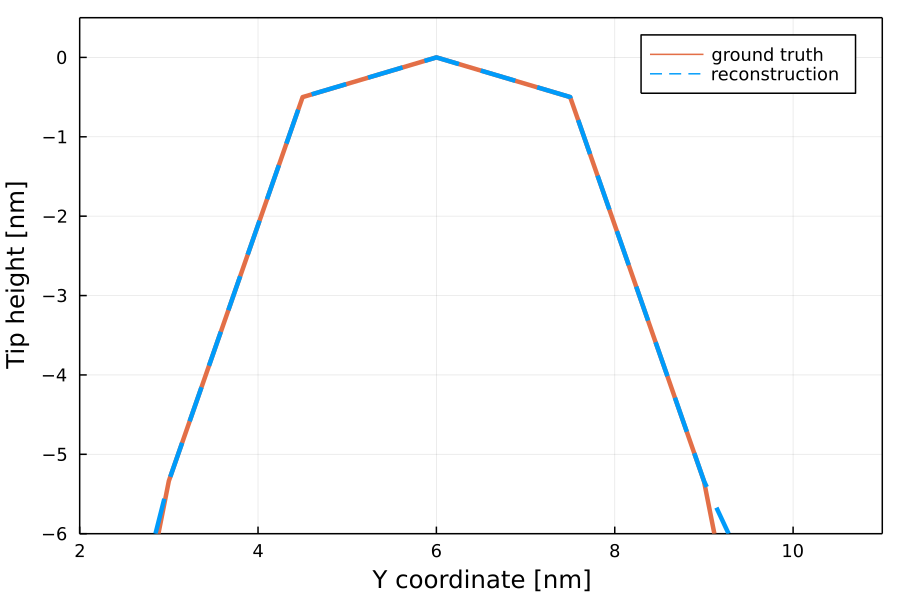

In [31]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 3] / 10.0, linewidth=3, label="ground truth", color=2)
p = plot!(collect(1:9) .* resolution / 10.0, P_array[1][:, 5] / 10.0, linewidth=3, label="reconstruction", framestyle = :box, linestyle=:dash, dpi=150, fmt=:png, color=1)
ylims!((-6, 0.5))
xlims!((2, 11))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [32]:
savefig(p, "blindtip_original03.png")

In [34]:
pyplot()

Plots.PyPlotBackend()

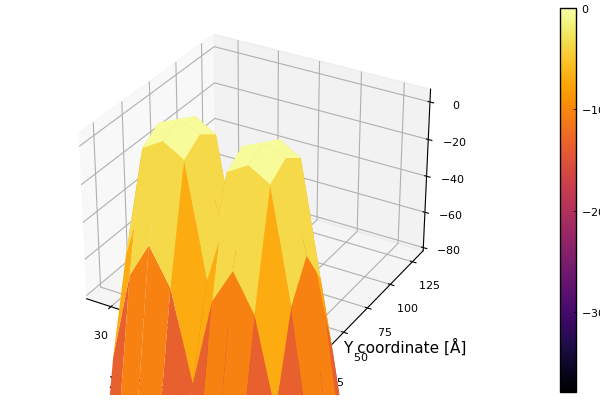

In [35]:
plot(collect(1:11) .* resolution, collect(1:9) .* resolution, tip, st=:surface)
zlims!((-80, 5))
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#zlabel!("Tip height [Å]", fontsize=35)

In [36]:
#tip_tmp = deepcopy(P_array[end])
#tip_tmp[tip .< -60.0] .= NaN

plot(collect(1:11) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, m_P ./ 10.0, st=:surface, dpi=150)
zlims!((-8, 0.5))
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Tip height [nm]", fontsize=35)

LoadError: UndefVarError: m_P not defined

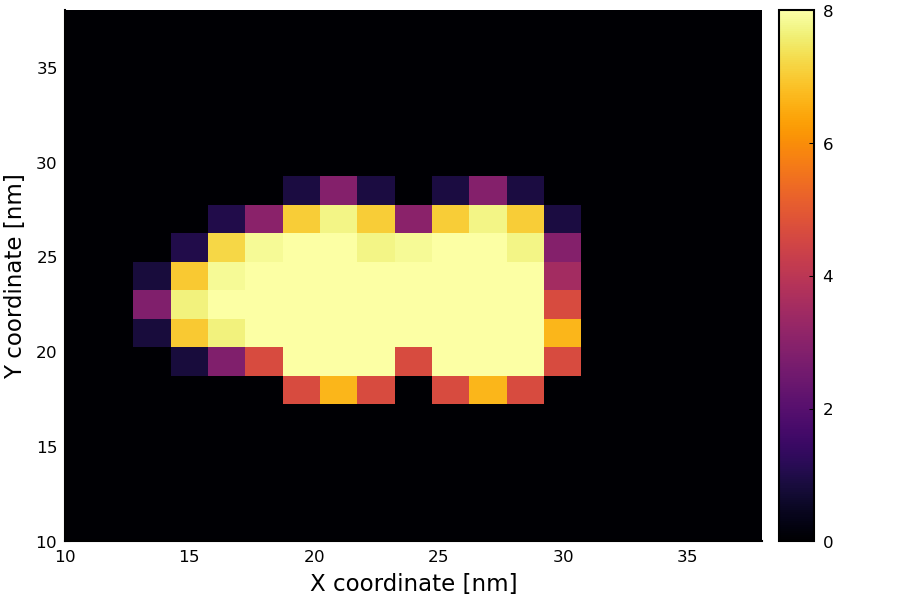

In [37]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [38]:
savefig(p, "blindtip_original04.png")

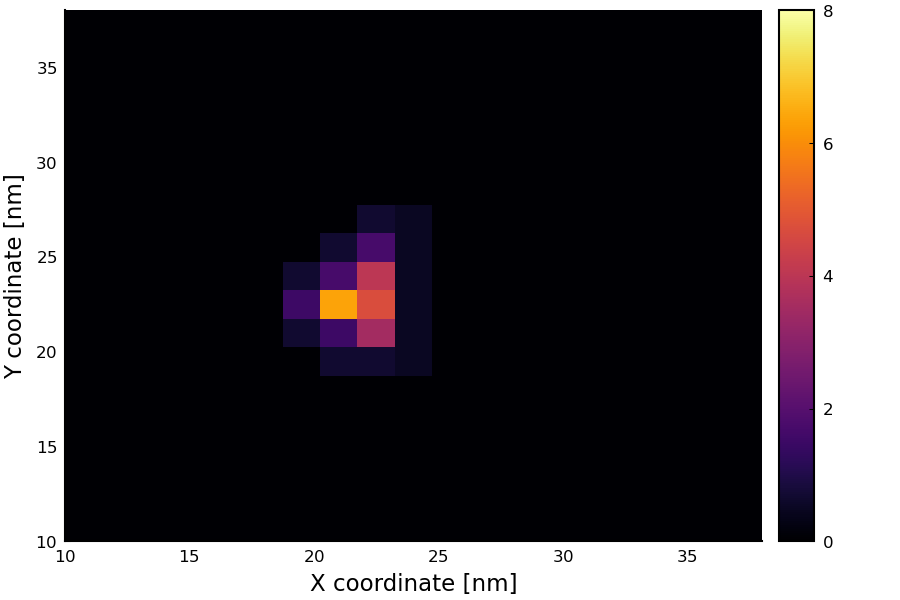

In [42]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images[1], P_array[1]) / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [43]:
savefig(p, "blindtip_original05.png")

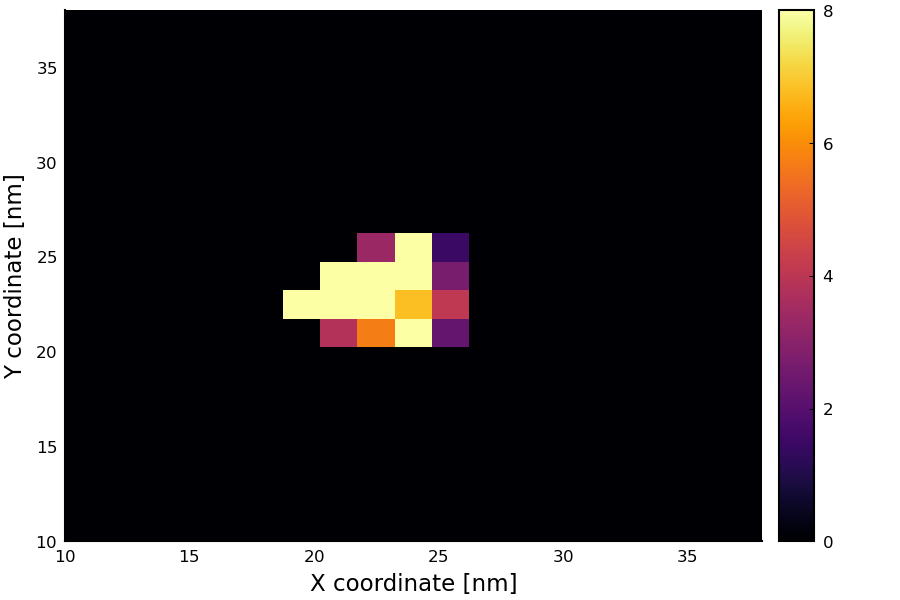

In [44]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [45]:
savefig(p, "blindtip_original06.png")